In [111]:
import polars as pl
import polars.selectors as cs
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import os
import sys

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
filter = '1h'

In [112]:
column = "gmp343_corrected"

In [113]:
df_2024 = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col(column) - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean()) \
    .filter(pl.col("system_id").is_in([3, 6])) \
    .filter(pl.col("gmp343_temperature") < 34.5)

In [114]:
system_ids = df_2024["system_id"].unique().to_list()
system_ids

[3, 6]

In [115]:
column = "gmp343_edge_corrected"

In [116]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "2025_L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col(column) - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean())

In [117]:
system_ids = df["system_id"].unique().to_list()
system_ids

[3, 6]

In [ ]:
def plot_scatter_with_trendline(df, x_col_name, y_col_name="diff", max_col=5, max_row=4, x_title="x_name", y_title="ACROPOLIS - Picarro (ppm)", title_text="title_name"):
    system_ids = df.select("system_id").unique().to_series().sort().to_list()
    num_systems = len(system_ids)
    
    fig, axes = plt.subplots(max_row, max_col, figsize=(5 * max_col, 5 * max_row), sharey=True)
    fig.suptitle(title_text, fontsize=16)
    
    axes = np.array(axes).reshape(max_row, max_col)  # Ensure correct shape
    
    for idx, system_id in enumerate(system_ids):
        if idx >= max_row * max_col:
            break
        row, col = divmod(idx, max_col)
        
        ax = axes[row, col]
        df_plot = df.filter(pl.col("system_id") == system_id)
        
        x = df_plot.select(x_col_name).to_numpy().flatten().reshape(-1, 1)
        y = df_plot.select(y_col_name).to_numpy().flatten().reshape(-1, 1)
        
        # Scatter plot
        ax.scatter(x, y, label=f"MC-{int(system_id)}", alpha=0.5)
        
        # Fit linear regression
        if len(x) > 1:
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            
            # Plot trendline
            ax.plot(x, y_pred, color="#D55E00", label=f"R²={r2:.2f}")
        
        ax.set_title(f"System: {int(system_id)}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_systems, max_row * max_col):
        row, col = divmod(idx, max_col)
        fig.delaxes(axes[row, col])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

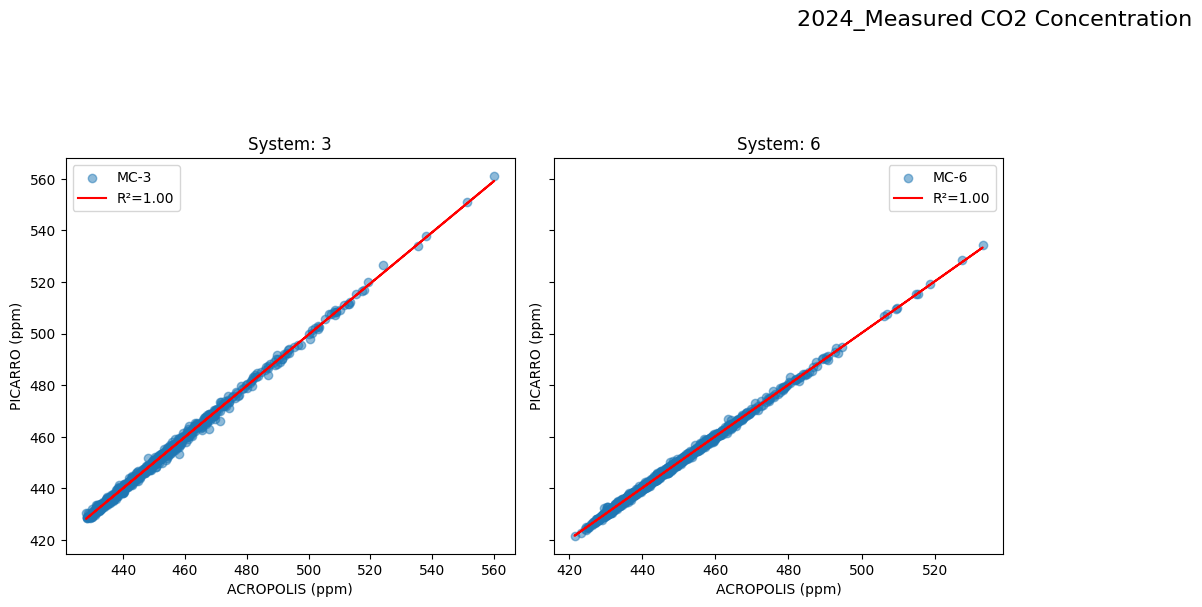

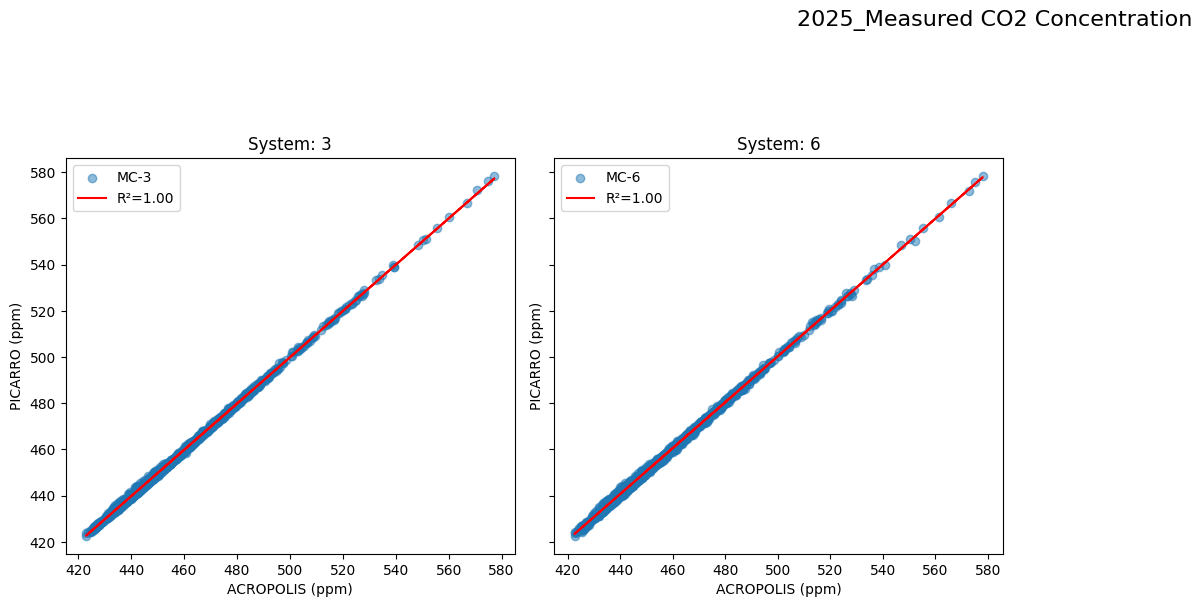

In [119]:
# parameters
x_col_name = "gmp343_corrected"
y_col_name = "picarro_corrected"
max_col = 4
max_row = 5
x_title = "ACROPOLIS (ppm)"
y_title = "PICARRO (ppm)"
title_text = "Measured CO2 Concentration" 

plot_scatter_with_trendline(df=df_2024, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text="2024_" + title_text)

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text="2025_" +title_text)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_scatter(
    df1: pl.DataFrame,
    df2: pl.DataFrame,
    system_ids: list[int],
    years=(2024, 2025),
    x_col_name="x_name",
    y_col_name="y_name",
    x_title="x_title",
    y_title="y_title",
    x_lim=None,
    y_lim=None,
    figsize=(10, 8),
    dpi=100
):
    dfs = [df1, df2]
    yrs = list(years)
    assert len(dfs) == len(yrs) == 2
    assert len(system_ids) == 2

    n_rows = len(system_ids)
    n_cols = len(yrs)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=figsize,
        dpi=dpi,
        sharey=True,
        sharex=False  # KEIN Teilen der x-Achse mehr
    )

    axes = np.array(axes).reshape(n_rows, n_cols)

    for i, sys_id in enumerate(system_ids):
        for j, (df, year) in enumerate(zip(dfs, yrs)):
            ax = axes[i, j]
            df_plot = df.filter(pl.col("system_id") == sys_id)
            x = df_plot.select(x_col_name).to_numpy().flatten()
            y = df_plot.select(y_col_name).to_numpy().flatten()

            ax.scatter(x, y, alpha=0.5)

            if len(x) > 1:
                model = LinearRegression()
                model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
                y_pred = model.predict(x.reshape(-1, 1)).flatten()
                ax.plot(x, y_pred, color="#D55E00", label='Linear Regression')
            ax.plot(x, np.zeros_like(x), '--', color='black', label='Baseline')

            if (int(sys_id) == 3) & (year == 2025):
                ax.set_title(f"System {int(sys_id)}: {year} (v2)")
            else:
                ax.set_title(f"System {int(sys_id)}: {year} (v1)")
                
            ax.set_xlabel(x_title)
            if j == 0:
                ax.set_ylabel(y_title)

            # eigene x-Limits pro Subplot
            if x_col_name == "gmp343_temperature":
                if not (int(sys_id) == 3) & (year == 2025):
                    if x_lim is not None:
                        ax.set_xlim(x_lim)
                    
            else:    
                if x_lim is not None:
                    ax.set_xlim(x_lim)
                    
            if y_lim is not None:
                ax.set_ylim(y_lim)

            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
            ax.legend()
            
    # Gemeinsame Legende für Regression & Baseline unten
    line_reg  = Line2D([0], [0], color="#D55E00",   label='Linear Regression')
    line_base = Line2D([0], [0], linestyle='--', color='black', label='Baseline')
    fig.legend(
        handles=[line_reg, line_base],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [177]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D

def plot_scatter(
    df1: pl.DataFrame,
    df2: pl.DataFrame,
    system_ids: list[int],
    years=(2024, 2025),
    x_col_name="x_name",
    y_col_name="y_name",
    x_title="x_title",
    y_title="y_title",
    x_lim=None,
    y_lim=None,
    figsize=(10, 8),
    dpi=100
):
    dfs = [df1, df2]
    yrs = list(years)
    assert len(dfs) == len(yrs) == 2
    assert len(system_ids) == 2

    n_rows = len(system_ids)
    n_cols = len(yrs)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=figsize,
        dpi=dpi,
        sharey=True,
        sharex=False
    )

    axes = np.array(axes).reshape(n_rows, n_cols)

    for i, sys_id in enumerate(system_ids):
        for j, (df, year) in enumerate(zip(dfs, yrs)):
            ax = axes[i, j]
            df_plot = df.filter(pl.col("system_id") == sys_id)
            x = df_plot.select(x_col_name).to_numpy().flatten()
            y = df_plot.select(y_col_name).to_numpy().flatten()

            # Scatter mit Zählung
            scatter = ax.scatter(
                x, y,
                alpha=0.5,
                label=f"n={len(x)}",
                color="#0072B2"
            )

            # Trendlinie & Baseline ohne Labels
            if len(x) > 1:
                model = LinearRegression()
                model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
                y_pred = model.predict(x.reshape(-1, 1)).flatten()
                ax.plot(x, y_pred, color="#D55E00")
            ax.plot(x, np.zeros_like(x), '--', color='black')

            # Titel und Achsen
            ax.set_title(f"System {int(sys_id)}: {year}")
            ax.set_xlabel(x_title)
            if j == 0:
                ax.set_ylabel(y_title)

            if x_col_name == "gmp343_temperature":
                if not (int(sys_id) == 3) & (year == 2025):
                    if x_lim is not None:
                        ax.set_xlim(x_lim)
                        
            if y_lim is not None:
                ax.set_ylim(y_lim)

            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

            # Nur Scatter-Legende pro Subplot
            ax.legend(loc='upper left')

    # Gemeinsame Legende für Regression & Baseline unten
    line_reg  = Line2D([0], [0], color="#D55E00",   label='Linear Regression')
    line_base = Line2D([0], [0], linestyle='--', color='black', label='Baseline')
    fig.legend(
        handles=[line_reg, line_base],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

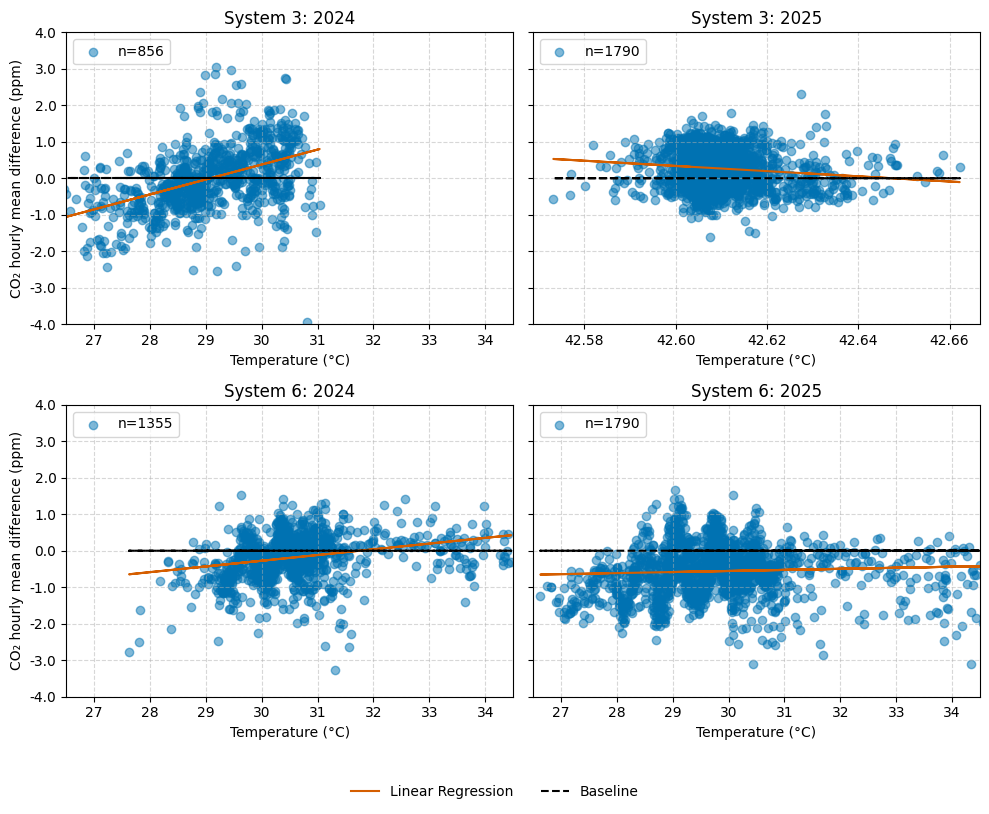

In [178]:
# parameters
x_col_name = "gmp343_temperature"
y_col_name = "diff"
max_col = 2
max_row = 1
y_title = "CO₂ hourly mean difference (ppm)"
x_title = "Temperature (°C)"

plot_scatter(
    df1=df_2024, 
    df2=df,
    system_ids=[3, 6],
    years=(2024, 2025),
    x_col_name=x_col_name,
    y_col_name=y_col_name, 
    x_title=x_title,
    y_title = y_title, 
    x_lim=(26.5, 34.5),
    y_lim=(-4, 4))

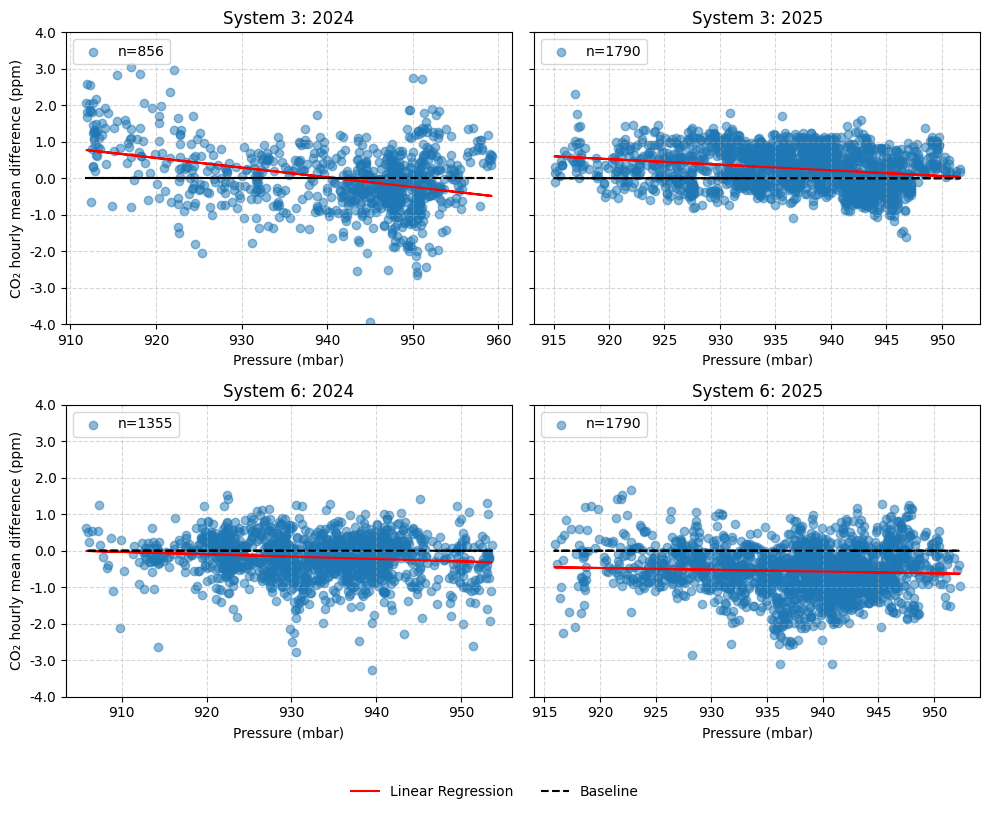

In [173]:
# parameters
x_col_name = "bme280_pressure"
y_col_name = "diff"
max_col = 2
max_row = 1
y_title = "CO₂ hourly mean difference (ppm)"
x_title = "Pressure (mbar)"


plot_scatter(
    df1=df_2024, 
    df2=df,
    system_ids=[3, 6],
    years=(2024, 2025),
    x_col_name=x_col_name,
    y_col_name=y_col_name, 
    x_title=x_title,
    y_title = y_title, 
    x_lim=(910, 961),
    y_lim=(-4, 4))

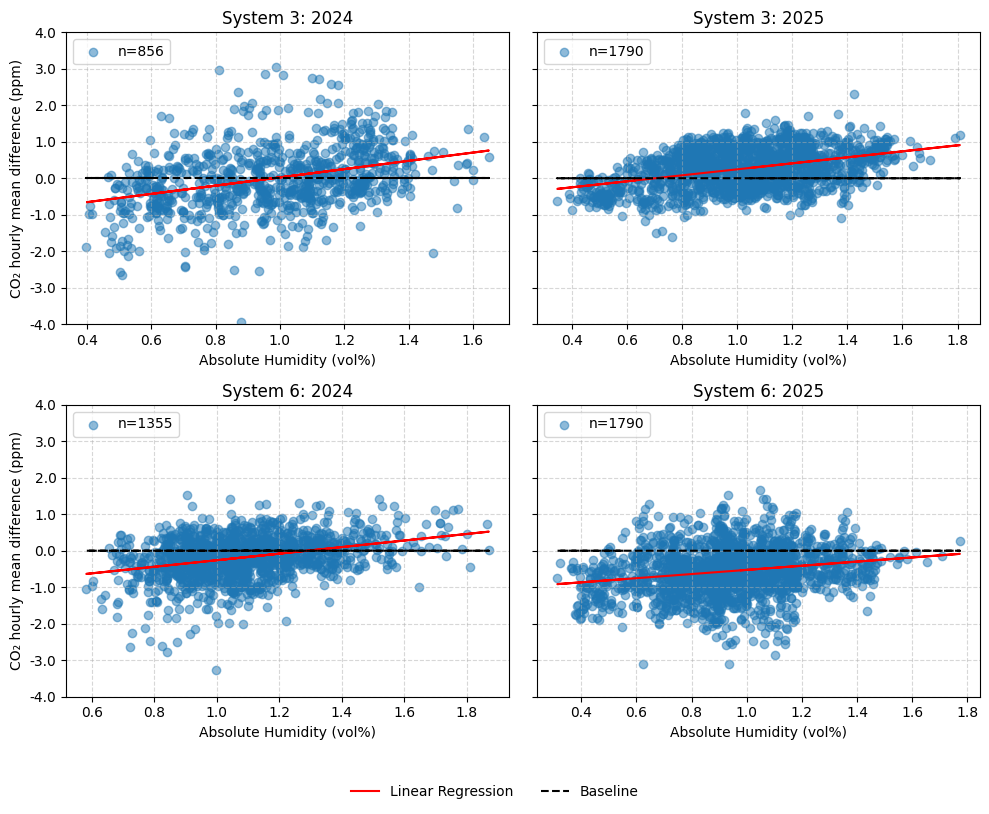

In [174]:
# parameters
x_col_name = "h2o_v%"
y_col_name = "diff"
max_col = 2
max_row = 1
x_title = "Absolute Humidity (vol%)"
y_title = "CO₂ hourly mean difference (ppm)"

plot_scatter(
    df1=df_2024, 
    df2=df,
    system_ids=[3, 6],
    years=(2024, 2025),
    x_col_name=x_col_name,
    y_col_name=y_col_name, 
    x_title=x_title,
    y_title = y_title, 
    x_lim=(0.3, 1.9),
    y_lim=(-4, 4))